<a href="https://colab.research.google.com/github/RileyWClarke/fftpca_note/blob/master/FFTPCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FFTPCA

In [53]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


#Potentially useful astropy stuff
import astropy
import astropy.io.ascii as ascii
from astropy.table import Table
from astropy.io import fits
from astropy.stats import LombScargle
from astropy.stats import sigma_clipped_stats
from astropy.stats import sigma_clip
from astropy.modeling import powerlaws
from astropy import constants as const
from astropy import units as u

#For reading in and organizing data
import pandas as pd
import requests
import json

#Misc
import scipy
import sklearn
from sklearn.preprocessing import scale

In [54]:
#Making Figures look nice
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 12

In [55]:
#from google.colab import drive
#drive.mount("/content/gdrive")

## Reading in Data

### Long Cadence Data

In [56]:
bjds = np.load('Data/bjds.npy')
fluxes = np.load('Data/fluxes.npy')
fluxerrs = np.load('Data/fluxerrs.npy')

# FFT Filtering

In [57]:
def invgaussian(a ,m, s, x):
    g = -a * np.exp(-(m-x)**2 / s**2) + 1 
    return g

In [58]:
def bandpass_ifft(t, flux, low_cutoff, high_cutoff, sample=1, 
                  M=None, inv_box=False, gf_sig = 1, Filter='box', Plot=''):
    """Bandpass filtering on a real signal using inverse FFT
    
    Inputs
    =======
    
    X: 1-D numpy array of floats, the real time domain signal (time series) to be filtered
    Low_cutoff: float, frequency components below this frequency will not pass the filter (physical frequency in unit of Hz)
    High_cutoff: float, frequency components above this frequency will not pass the filter (physical frequency in unit of Hz)
    sample: float, the sampling frequency of the signal (physical frequency in unit of Hz)    
    M: idk lmao
    inv_box: If using box filter, setting inv=True filters out frequencies outside the box
    Filter: Default filter is box, can choose 'Gaussian' also
    
    Notes
    =====
    1. The input signal must be real, not imaginary nor complex
    2. The Filtered_signal will have only half of original amplitude. Use abs() to restore. 
    3. In Numpy/Scipy, the frequencies goes from 0 to F_sample/2 and then from negative F_sample to 0. 
    
    """        
    #perform fft
    spectrum = np.fft.rfft(flux) 
    freq = np.fft.rfftfreq(len(flux), sample)
    freq_sort = np.sort(spectrum)
    
    #calculate the index of the cut off points
    lc = np.abs(freq) < Low_cutoff
    hc = np.abs(freq) > High_cutoff
    between = ~(lc + hc)
    
    ps = np.abs(spectrum)**2
    if ('PS' in Plot) or ('All' in Plot):
      plt.plot(freq, ps)
      plt.title("power spectrum")
      plt.xlabel('Frequency (1/day)')
      plt.ylabel('Power Spectral Density')
      #plt.xlim(0,100)
      #plt.savefig('Figures/spec.png', bbox_inches='tight', pad_inches=0.5)
      plt.show()

    if ('DFT' in Plot) or ('All' in Plot):
      plt.plot(freq, spectrum)
      #plt.plot(freq[between], spectrum[between], alpha=0.5)
      plt.title("real fourier transform ")
      plt.xlabel('Frequency (1/day)')
      plt.ylabel('Amplitude')
      #plt.xlim(0,100)
      #plt.savefig('Figures/fft.png', bbox_inches='tight', pad_inches=0.5)
      plt.show()
    
    
    
    if Filter == 'box':
    
      #filtered_spectrum = spectrum.copy()
    
      if inv_box == True:
        x_1 = np.arange(0, Low_cutoff, 0.1)
        x_2 = np.arange(High_cutoff, np.max(freq), 0.1)
        plt.plot(freq, spectrum)
        plt.fill_between(x_1, [plt.ylim()[0]] * len(x_1), 
                     [plt.ylim()[1]] * len(x_1), color='r', alpha=0.3)
        plt.fill_between(x_2, [plt.ylim()[0]] * len(x_2), 
                     [plt.ylim()[1]] * len(x_2), color='r', alpha=0.3)
        plt.title("range to suppress")
        plt.figure()
        filtered_spectrum[lc] = 0.
        filtered_spectrum[hc] = 0.
      else:
        x_ = np.arange(Low_cutoff, High_cutoff, 0.1)
        plt.plot(freq, spectrum)
        plt.fill_between(x_, [plt.ylim()[0]] * len(x_), 
                     [plt.ylim()[1]] * len(x_), color='r', alpha=0.3)
        plt.title("range to suppress")
        plt.figure()
        filtered_spectrum[between] = 0.
    
    if Filter == 'Gaussian':
      ig = invgaussian(1, np.median([low_cutoff,high_cutoff]), gf_sig, freq)
      filtered_spectrum = spectrum * ig
      if ('filter' in Plot) or ('All' in Plot):
        plt.plot(freq, ig)
        plt.title('Gaussian Filter')
        #plt.savefig('Figures/gfilter.png')
        #plt.xlim(0,100)
        plt.figure()

    if ('spec_filtered' in Plot) or ('All' in Plot):
      plt.plot(freq, filtered_spectrum, label="filtered spectrum")
      plt.plot(freq, spectrum, c='k', ls="--", label="spectrum", alpha=0.5)
      plt.title("Unfiltered vs. Filtered Spectrum")
      plt.xlabel('Frequency (1/day)')
      plt.ylabel('Amplitude')
      ldg = plt.legend(fontsize=12)
      #plt.xlim(0,100)
      #plt.savefig('Figures/filter_compare.png', bbox_inches='tight', pad_inches=0.5)
      plt.figure()

    filtered_signal = np.fft.irfft(filtered_spectrum)  # Construct filtered signal

    if ('signal_filtered' in Plot) or ('All' in Plot):
      fig = plt.figure(figsize=(15,10)) 
      plt.plot(t, filtered_signal, label="filtered signal")
      plt.plot(t, flux, c='k', ls="--", label="original signal", alpha=0.5)
      plt.xlabel('Time')
      plt.ylabel('Amplitude')
      plt.title("Unfiltered vs. Filtered Signal")
      #plt.savefig('Figures/filtered_signal.png', bbox_inches='tight', pad_inches=0.5)
      plt.legend()
      #Filtered_signal = np.zeros_like(Filtered_signal)
    return spectrum, freq, filtered_spectrum, filtered_signal, Low_cutoff, High_cutoff

In [59]:
dfts = []
pspectra = []
for i, flux in enumerate(fluxes):
  Low_cutoff, High_cutoff, F_sample = 4, 6, np.diff(bjds[i])[0]
  Spectrum, frequency, Filtered_spectrum, Filtered_signal, Low_freq, High_freq = bandpass_ifft(bjds[i], flux, Low_cutoff, High_cutoff, 
                          F_sample, gf_sig = 1, Filter='Gaussian')

  dfts.append(Spectrum)
  pspectra.append(np.abs(Spectrum)**2)

# PCA with Spectra

In [60]:
from sklearn.decomposition import PCA

In [61]:
pspec_dict = {}

for j, spec in enumerate(pspectra):
  pspec_dict["spec{0}".format(j)] = spec

pspec_df = pd.DataFrame(data=pspec_dict)

In [62]:
pspec_df.head()

,spec0,spec1,spec2,spec3,spec4,spec5,spec6,spec7,spec8,spec9,...,spec990,spec991,spec992,spec993,spec994,spec995,spec996,spec997,spec998,spec999
0,2444.330836,3491.401379,17691.849961,24.533747,6.163901e+03,631.853491,276.295785,15020.322357,195.025521,22788.457538,...,33.260864,8.329918e+01,429.686300,3.495277e+02,10.796121,604.412834,74.000805,15.231185,1578.632726,0.325671
1,188558.097947,24932.464107,27502.736287,11596.062242,1.329584e+06,21881.098032,7824.408002,1708.935209,33900.530576,106001.638933,...,39012.940662,2.852149e+04,221522.421770,2.701112e+05,16677.137662,78130.343520,54050.845570,7015.700238,701.526990,33601.833088
2,137018.884662,40621.698347,26031.074624,99011.951142,1.027931e+05,60128.856707,74299.255923,12094.348022,523997.575650,84198.566845,...,1388.401516,7.674183e+04,411180.284071,1.482621e+05,86068.824882,164012.481497,86414.240316,6035.216574,83485.735451,23158.742652
3,8088.677230,1279.610214,25525.877039,7997.888711,1.717962e+05,15107.184941,41440.697136,7385.217256,68834.422406,119432.561355,...,1653.227609,1.331502e+05,370.357912,2.498437e+05,193504.408819,8440.866909,14802.618608,16771.383378,4520.744261,5862.505022
4,38741.302025,32673.694499,103469.748680,7106.695823,1.824596e+05,8008.003119,236357.760858,92934.117258,17320.909253,47588.485578,...,13031.507391,1.834104e+06,7710.168343,2.331563e+06,44564.275246,32945.930265,111682.212681,26327.696869,36660.220971,1539.411083


In [63]:
x = pspec_df.values
x = scale(x, axis=0)

In [64]:
pca = PCA()

pca.fit(x)

X = pca.transform(x)

pca_df = pd.DataFrame(data = X)
print(pca_df.shape)
pca_df.head()

(1735, 1000)


,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,-0.976851,5.335109,-0.635924,0.426727,-0.149198,0.594171,1.446605,0.675921,0.419251,-0.170973,...,9.705129e-05,-1.991950e-05,1.209915e-05,1.607438e-05,-1.457954e-05,-5.352218e-06,-2.024611e-05,-1.570068e-05,-1.613461e-06,-2.141829e-07
1,204.148185,295.006662,-6.975532,40.328249,32.018923,-11.744238,-18.781720,-3.156247,-2.028993,1.815808,...,-7.305529e-08,1.089954e-08,-7.434678e-09,-1.106568e-08,2.230695e-08,5.975956e-09,2.087342e-08,1.388444e-08,2.734884e-09,-6.735569e-10
2,372.084336,-27.892496,241.148784,-66.463167,-26.688698,-5.604747,-7.383737,1.605789,-2.771667,-1.688595,...,3.325794e-08,-3.521616e-08,6.196570e-08,-4.798948e-08,1.852050e-08,-2.399049e-08,-1.306440e-08,-1.052070e-08,-1.940447e-08,2.089709e-08
3,267.782555,-62.642841,-25.544949,204.578245,-105.998911,-2.221424,-18.307529,2.020841,-3.571498,1.620010,...,-8.086415e-08,-9.126746e-08,3.000561e-08,6.304849e-08,-1.127478e-08,-1.099796e-10,-2.337176e-08,-2.024113e-08,2.418073e-08,-2.636521e-08
4,234.667100,-70.390801,-15.216099,53.341804,165.906755,108.825482,-10.195769,-12.742281,-1.464725,5.277979,...,4.346168e-08,-2.845333e-08,-1.768161e-08,3.585069e-08,-2.087025e-08,-1.040076e-08,1.059473e-08,-1.722237e-08,7.806284e-09,-1.508386e-09


## Bandpass Filtering First 2 Components

In [65]:
def gaussian(a, m, s, x):
    g = a * np.exp(-(m-x)**2 / s**2) 
    return g

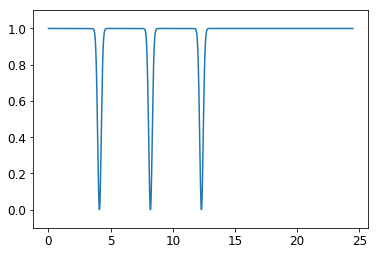

In [66]:
def hrm_gfilter(x, s, fund, nhrm=0, amps=np.ones(len(x))):

  fhrms = np.array([fund])

  for i in range(2, nhrm+2):
    fhrms = np.append(fhrms, i*fund)

  filt = np.ones(len(x))

  for hrm, amp in zip(fhrms, amps):
    filt *= invgaussian(amp,hrm,s,x) 
   # filt += gaussian(amp,hrm,s,x)

  return filt

filt = hrm_gfilter(frequency, 0.2, 4.1, 2)

plt.plot(frequency, filt)
plt.ylim(-0.1,1.1);

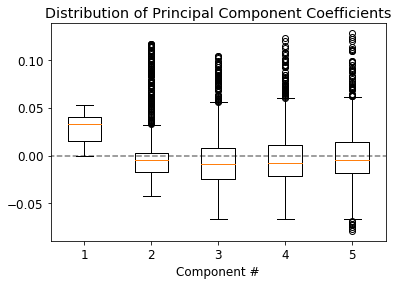

In [67]:
# Multiple box plots on one Axes
fig, ax = plt.subplots()
ax.boxplot([pca.components_[0], pca.components_[1], pca.components_[2], pca.components_[3],pca.components_[4]])
plt.hlines(0, 0, 7, linestyle='--', alpha=0.5)
plt.xlabel('Component #')
plt.title('Distribution of Principal Component Coefficients')
plt.xlim(0.5,5.5)
plt.savefig('Figures/box.png', dpi=100, bbox_inches='tight')
plt.show()

In [68]:
d = {'pc1':pca.components_[0],'pc2':pca.components_[1],'pc3':pca.components_[2],'pc4':pca.components_[3],'pc5':pca.components_[4]}
coeff_df = pd.DataFrame(data=d)
coeff_df.to_csv('Data/coeffs.csv')

# PCA with DFTs

In [69]:
dft_dict = {}


for j, dft in enumerate(dfts):
  dft_dict["dft{0}".format(j)] = dft

dft_df = pd.DataFrame(data=dft_dict)

In [70]:
y = dft_df.values
y.real = scale(y.real, axis=0)
y.imag = scale(y.imag, axis=0)

In [71]:
print(y[:,0].real.mean(), y[:,0].imag.mean())

2.047673590086744e-18 8.190694360346977e-18


In [72]:
print(y[:,0].real.std(), y[:,0].imag.std())

1.0 1.0


In [73]:
pca2 = PCA()

pca2.fit(y.real)

Y = pca2.transform(y.real)

pca2_df = pd.DataFrame(data = Y)
print(pca2_df.shape)


pca2i = PCA()

pca2i.fit(y.imag)

Yi = pca2i.transform(y.imag)

pca2i_df = pd.DataFrame(data = Yi)
print(pca2i_df.shape)

(1735, 1000)
(1735, 1000)


## Bandpass Filtering ALL Components

In [74]:
def pc_thr(dataframe, frequency, fund, threshold):
  pcs = dataframe.values
  pc_list = []
  f_ind = np.argmin(np.abs(frequency - fund))
  fstep = np.diff(frequency).mean()
  std = 0.1
  pts_per_std = int(std/fstep)

  for i, pc in enumerate(pcs):
   
    local_avg = np.mean(np.concatenate((pc[(f_ind - pts_per_std*2):(f_ind - pts_per_std*1)], 
                       pc[(f_ind + pts_per_std*1):(f_ind + pts_per_std*2)])))
    local_std = np.std(np.concatenate((pc[(f_ind - pts_per_std*2):(f_ind - pts_per_std*1)], 
                       pc[(f_ind + pts_per_std*1):(f_ind + pts_per_std*2)])))

    if np.abs(pc[f_ind]) > np.abs( local_avg * threshold * local_std ):
 
      pc_list.append(i)

    else:
      pass

  return pc_list

In [75]:
ss = pc_thr(pca2_df.T, frequency, fund=4.09, threshold=2)
len(ss)

820

In [76]:
### BANDPASS FILTERING PCs

def pc_filt(dataframe, frequency, fund, std, nhrms, subset=None):

  '''
  Takes a set of Discrete Fourier Transform PCs with a common frequency domain 
  and bandpass filters them on a given 
  fundamental frequency and associated harmonics
  with a Gaussian filter of standard deviation "std"
  '''

  #Create pcs and new_pcs
  new_pcs = []
  pcs = dataframe.values

  #Select subset of pcs if applicable:
  if subset != None:
    pcs = np.take(pcs, subset, axis=0)
  else:
    pass

  #Bandpass filter pcs:
  for i, pc in enumerate(pcs):

    fstep = np.diff(frequency).mean()
    pts_per_std = int(std/fstep)
    dftpc = np.copy(pc)  
    hrm_inds = []

    for i in range(1,nhrms+2):
      hrm_inds.append(np.where(np.abs(frequency - fund*i) == np.abs(frequency - fund*i).min())[0][0])


    for k, ind in enumerate(hrm_inds):
      local_avg = np.mean(np.concatenate((dftpc[(ind - pts_per_std*2):(ind - pts_per_std*1)], 
                       dftpc[(ind + pts_per_std*1):(ind + pts_per_std*2)])))

      dftpc[5:] -= local_avg
      dftpc[5:] *= hrm_gfilter(frequency[5:], std, fund*(k+1))
      dftpc[5:] += local_avg

    new_pcs.append(dftpc)

  #Replace modified pcs in the ensemble
  if subset != None:
    prod = dataframe.values.copy()
    for n, m in zip(range(len(subset)), subset):
      prod[m] = new_pcs[n]
    return prod

  return np.array(new_pcs)

In [77]:
real_new_pcs = pc_filt(pca2_df.T, frequency, fund=4.09, std=0.1, nhrms=2, subset=ss)
im_new_pcs = pc_filt(pca2i_df.T, frequency, fund=4.09, std=0.1, nhrms=2, subset=ss)

In [78]:
nComp=1000 #Selects how many comps to use
Yhat = np.dot(real_new_pcs.T[:,0:nComp], pca2.components_[0:nComp,:])
Yhati = np.dot(im_new_pcs.T[:,0:nComp], pca2i.components_[0:nComp,:])

Yhat1c = Yhat + (1j)*Yhati

In [79]:
processed = []

for i in range(1000):
  processed.append(np.fft.irfft(Yhat1c[:,i]))

processed = np.array(processed)

np.save('Data/processed_lcs_1000pc', processed)